# Data Gather

### **library imports**

In [43]:
import cv2
import mediapipe as mp
import numpy as np
import csv
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import os  # Add import for os module
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd

### **Initialize MediaPipe Pose**

In [44]:
'''This script uses MediaPipe to process video frames for pose estimation.'''
mp_pose = mp.solutions.pose  # Access MediaPipe's pose solution
mp_drawing = mp.solutions.drawing_utils  # Utility for drawing landmarks on frames
pose = mp_pose.Pose(
    static_image_mode=False,  # Process video frames in a continuous stream
    min_detection_confidence=0.5,  # Minimum confidence for detecting landmarks
    min_tracking_confidence=0.5  # Minimum confidence for tracking landmarks
)

### **Function to calculate the angle between two points in the XOY plane**

In [45]:
def angle_from_origin_xoy(p1, p2):
    '''Calculate the angle between two points in the XOY plane.
    Args:
        p1 (tuple): Coordinates of the first point (x1, y1).
        p2 (tuple): Coordinates of the second point (x2, y2).
        Returns:
        float: The angle in degrees between the line connecting the two points and the x-axis.'''
    delta_x = p2[0] - p1[0]
    delta_y = p1[1] - p2[1]  # Invert y-axis for Cartesian coordinates
                
    if delta_x == 0 and delta_y == 0:
        return 0.0  # Handle identical points
                
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    angle = abs(angle)  # Convert -180 to -90 to 90 to 180
    if angle > 90:  # Second and third quadrants
        angle = 180 - angle  # Map 90-180 to 90-0            
    return angle

### **Function to process video and calculate angles**

In [46]:
def process_video_and_calculate_angles(video_path, landmark_to_compare, landmark_name, classification_class):
    """
    Process a video to calculate angles between a reference point and a specified landmark.
    Args:
        video_path (str): Path to the input video file.
        landmark_to_compare (int): Index of the landmark to compare against the reference point.
        landmark_name (str): Name of the landmark for labeling.
        classification_class (str): Classification class for the landmark.
    Returns:
        pd.DataFrame: DataFrame containing frame number, angle, landmark name, and classification.
    """

    # Initialize an empty DataFrame with VideoName column
    angles_data = pd.DataFrame(columns=["Frame", "Angle (degrees)"])
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    scale = (800, 600)
    frame_atual = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            print("End of video or cannot read the frame.")
            break

        imagem_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultado = pose.process(imagem_rgb)

        if resultado.pose_landmarks:
            mp_drawing.draw_landmarks(frame, resultado.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Get reference point (midpoint between hips)
            left_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
            ref_x = (left_hip.x + right_hip.x) / 2
            ref_y = (left_hip.y + right_hip.y) / 2

            # Use the index directly to get the specified landmark
            target_landmark = resultado.pose_landmarks.landmark[int(landmark_to_compare)]

            # Convert normalized coordinates to image coordinates
            h, w, _ = frame.shape
            ref_pt = (int(ref_x * w), int(ref_y * h))
            target_pt = (int(target_landmark.x * w), int(target_landmark.y * h))

            # Draw points
            cv2.circle(frame, ref_pt, 8, (0, 255, 0), -1)
            cv2.circle(frame, target_pt, 8, (0, 0, 255), -1)

            # Draw line
            cv2.line(frame, ref_pt, target_pt, (255, 255, 0), 2)

            # Calculate angle
            angulo = angle_from_origin_xoy(ref_pt, target_pt)

            if angulo is not None:
                # Append the new row to the DataFrame
                angles_data.loc[len(angles_data)] = [frame_atual, angulo]

                # Display angle
                cv2.putText(frame, f"Angle: {angulo:.1f} deg", (target_pt[0]+10, target_pt[1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
            else:
                print(f"Frame {frame_atual}: Unable to calculate angle.")

        frame_resized = cv2.resize(frame, scale)
        cv2.imshow("Angle Visualization", frame_resized)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_atual += 1
    cap.release()
    cv2.destroyAllWindows()
    
    angles_data["Landmark"] = landmark_name
    angles_data["Classification"] = classification_class
    angles_data["Video Name"] = os.path.basename(video_path)  # Add video name to DataFrame
    
    return angles_data


### **Function to process csv and normalize data**

In [47]:
import os

def process_angles_data(data): 
    """
    Process angles data to filter, normalize, and calculate velocity and acceleration.
    Args:
        data (pd.DataFrame): DataFrame containing angles data with columns 'Frame' and 'Angle (degrees)'.
    Returns:
        pd.DataFrame: Processed DataFrame with additional columns for filtered angles, velocity, and acceleration.
    """

    # Butterworth low-pass filter function
    def butter_lowpass_filter(data, cutoff, fs, order):
        b, a = butter(order, cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    # Define filter parameters
    order = 4
    cutoff = 0.2
    fps = 30

    # Apply the filter to the Angle (degrees) column
    data['Filtered Angle (degrees)'] = butter_lowpass_filter(data['Angle (degrees)'], cutoff, fps, order)

    # Calculate velocity and acceleration
    data['velocity'] = np.gradient(data['Filtered Angle (degrees)'], data['Frame'])
    data['acceleration'] = np.gradient(data['velocity'], data['Frame'])

    # Normalize velocity and acceleration
    scaler = MinMaxScaler()
    data[['velocity_normalized', 'acceleration_normalized']] = scaler.fit_transform(
        data[['velocity', 'acceleration']]
    )

    # Add a new column to convert frames to seconds
    data['Time (seconds)'] = data['Frame'] / fps

    return data

### **Join frames For Each Landmark Video to get STD e Medium**

In [48]:
def process_video_stats(df_normalized_data, data_path):
    '''Process video statistics to calculate summary statistics for each second.
    Args:
        df_normalized_data (pd.DataFrame): DataFrame containing normalized data with columns for angles, velocity, and acceleration.
    Returns:
        pd.DataFrame: DataFrame containing summary statistics for each second of the video.'''


    # Group by each second
    grouped = df_normalized_data.groupby(df_normalized_data['Time (seconds)'].astype(int))
    stats = grouped.agg({
            'Filtered Angle (degrees)': ['std', 'mean', 'median', 'min', 'max'],
            'velocity': ['std', 'mean', 'median', 'min', 'max'],
            'acceleration': ['std', 'mean', 'median', 'min', 'max']
        }).reset_index()
    # Flatten MultiIndex columns
    stats.columns = ['Time (seconds)',
                        'angle_std', 'angle_medium', 'angle_median', 'angle_min', 'angle_max',
                        'velocity_std', 'velocity_medium', 'velocity_median', 'velocity_min', 'velocity_max',
                        'acceleration_std', 'acceleration_medium', 'acceleration_median', 'acceleration_min', 'acceleration_max']
    stats['Classification'] = df_normalized_data['Classification']
    stats['Landmark'] = df_normalized_data['Landmark']
    stats['Video Name'] = df_normalized_data['Video Name']  # Use the first video name for all rows
    
    # Generate processed file path using landmark and classification
    landmark = df_normalized_data['Landmark'].iloc[0]
    classification = df_normalized_data['Classification'].iloc[0]
    processed_landmark_video_path = f"{data_path}/{landmark}_{classification}_stats.csv"
    stats.to_csv(processed_landmark_video_path, index=False)

    # Save the stats DataFrame to CSV
    stats.to_csv(processed_landmark_video_path, index=False)
    print(f"Processed statistics saved to {processed_landmark_video_path}")
    return stats

### **Join all processed CSV files from the videos folder**

In [49]:
def join_csv_files(folder):
    """
    Join all CSV files in the specified folder into a single DataFrame.
    Args:
        video_folder (str): Path to the folder containing CSV files.
    Returns:
        pd.DataFrame: DataFrame containing combined data from all CSV files.
        string: Saves the combined DataFrame to a CSV file named "all_landmarks_data_Processed_combined.csv"."
    """
    import glob
    import pandas as pd

    # Find all CSV files in the specified folder
    csv_files = glob.glob(os.path.join(folder, "*_stats.csv"))

    # Read and concatenate all CSV files
    df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
    
    # Save the combined stats DataFrame to a CSV file
    all_stats_csv_path = os.path.join(folder, "all_landmarks_data_Processed_combined.csv")
    df_all.to_csv(all_stats_csv_path, index=False)
    print(f"Combined stats CSV saved to: {all_stats_csv_path}")
    return df_all, all_stats_csv_path


### **Define the landmarks of interest**

In [50]:
landmarks_ids = {
    "head": 0,  # Head (nose landmark)
    "left_wrist": 15,  # Left wrist
    "right_wrist": 16,  # Right wrist
    "left_ankle": 27,  # Left ankle
    "right_ankle": 28  # Right ankle
}
print("Landmarks de interesse definidos:", landmarks_ids)


Landmarks de interesse definidos: {'head': 0, 'left_wrist': 15, 'right_wrist': 16, 'left_ankle': 27, 'right_ankle': 28}


### **Gather data from videos**

In [126]:
videos_folder = '.\\Videos\\'
data_folder = '.\\Data\\'
videos = {
    'impro_free.MP4': 'direct',
    'Phrase3.mp4': 'indirect',
}

def get_videos_data(videos, landmarks, data_folder, videos_folder):
    for video, classification in videos.items():
        for landmark_name, landmark_index in landmarks.items():
            angles_data = process_video_and_calculate_angles(videos_folder + video, landmark_index, landmark_name, classification)
            df_normalized_data = process_angles_data(angles_data)
            df_stats = process_video_stats(df_normalized_data, data_folder)
    
#get_videos_data(videos, landmarks_ids, data_folder, videos_folder)
df_all_stats, all_stats_csv_path = join_csv_files(data_folder)

# Print the path of the combined CSV file
print(f"Combined stats CSV saved to: {all_stats_csv_path}")

Combined stats CSV saved to: .\Data\all_landmarks_data_Processed_combined.csv
Combined stats CSV saved to: .\Data\all_landmarks_data_Processed_combined.csv


### **Print DataFrame statistics**

In [76]:
df_all_stats.describe(include='all')
df_all_stats.head()

,Time (seconds),angle_std,angle_medium,angle_median,angle_min,angle_max,velocity_std,velocity_medium,velocity_median,velocity_min,velocity_max,acceleration_std,acceleration_medium,acceleration_median,acceleration_min,acceleration_max,Classification,Landmark,Video Name
0,0,5.365647,84.625015,86.786068,74.732164,89.574841,1.344626,-0.007014,0.001301,-2.563390,1.987233,0.367779,-0.022758,-0.146798,-0.567774,0.751106,direct,head,impro_free.MP4
1,1,3.315042,86.818919,87.834922,75.805648,90.362379,1.084394,-0.468373,-0.347733,-2.848373,1.094180,0.307380,-0.063935,-0.044919,-0.648420,0.479610,direct,head,impro_free.MP4
2,2,5.241235,73.424766,72.950223,65.845076,81.226126,1.289142,-0.109646,-0.270036,-2.463498,1.733393,0.322133,0.081773,0.187327,-0.442534,0.430576,direct,head,impro_free.MP4
3,3,5.021058,80.130690,80.697612,71.123840,86.462213,0.871286,0.203919,0.466886,-1.171465,1.138229,0.173462,-0.012602,0.009436,-0.255834,0.347609,direct,head,impro_free.MP4
4,4,3.462330,81.138311,79.370084,76.797861,88.111519,0.981011,0.050203,-0.041963,-1.531674,2.057611,0.354296,0.004179,0.059731,-0.785664,0.512666,direct,head,impro_free.MP4


In [53]:
df_all_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time (seconds)       120 non-null    int64  
 1   angle_std            120 non-null    float64
 2   angle_medium         120 non-null    float64
 3   angle_median         120 non-null    float64
 4   angle_min            120 non-null    float64
 5   angle_max            120 non-null    float64
 6   velocity_std         120 non-null    float64
 7   velocity_medium      120 non-null    float64
 8   velocity_median      120 non-null    float64
 9   velocity_min         120 non-null    float64
 10  velocity_max         120 non-null    float64
 11  acceleration_std     120 non-null    float64
 12  acceleration_medium  120 non-null    float64
 13  acceleration_median  120 non-null    float64
 14  acceleration_min     120 non-null    float64
 15  acceleration_max     120 non-null    flo

# Training

### **Necessary Imports**

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [67]:
# Load combined stats CSV
df_all = pd.read_csv(all_stats_csv_path)
# Features and target
X = df_all[['angle_std', 'angle_medium', 'angle_median', 'angle_min', 'angle_max',
            'velocity_std', 'velocity_medium', 'velocity_median', 'velocity_min', 'velocity_max',
            'acceleration_std', 'acceleration_medium', 'acceleration_median', 'acceleration_min', 'acceleration_max']]
y = df_all['Classification']

### **Gather all processed CSVs and Split Data for Training**

In [114]:
# Separate classes
df_direct = df_all_stats[df_all_stats['Classification'] == 'direct']
df_indirect = df_all_stats[df_all_stats['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features and target for balanced data
X_balanced = df_balanced[X.columns]
y_balanced = df_balanced['Classification']

# Split balanced data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Correct scaling process
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_test = scaler.transform(X_test)       # Transform test data using the same scaler

In [111]:
# Split balanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Correct scaling process
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_test = scaler.transform(X_test)       # Transform test data using the same scaler

### **Create and Build Model**

In [115]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and report
y_pred = rf.predict(X_test)

### **Test Model**

              precision    recall  f1-score   support

      direct       0.94      0.94      0.94        18
    indirect       0.93      0.93      0.93        14

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



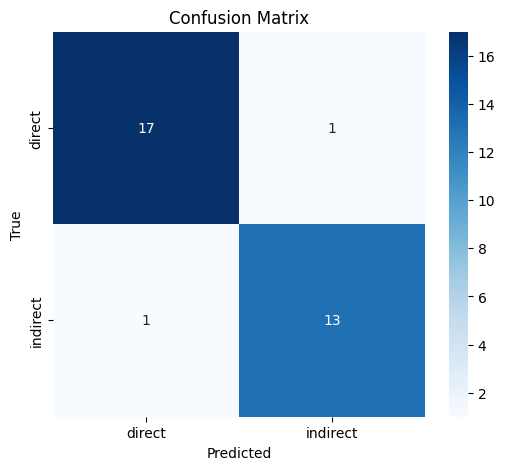

Feature Importances:
acceleration_std: 0.1220
angle_max: 0.1079
velocity_std: 0.0936
velocity_min: 0.0799
velocity_max: 0.0783
acceleration_max: 0.0770
acceleration_min: 0.0683
angle_medium: 0.0656
angle_min: 0.0577
angle_std: 0.0537
acceleration_median: 0.0436
velocity_median: 0.0420
velocity_medium: 0.0403
angle_median: 0.0368
acceleration_medium: 0.0333


C:\Users\asus\AppData\Local\Temp\ipykernel_9128\279346702.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


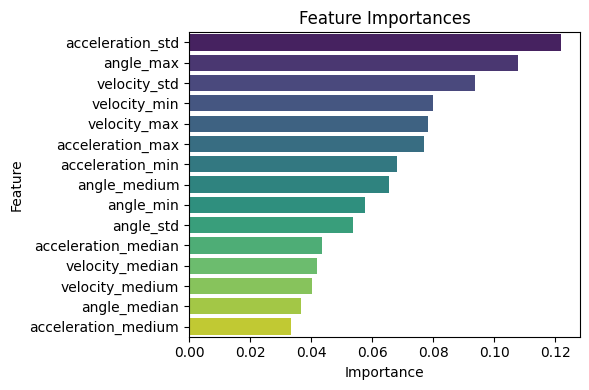

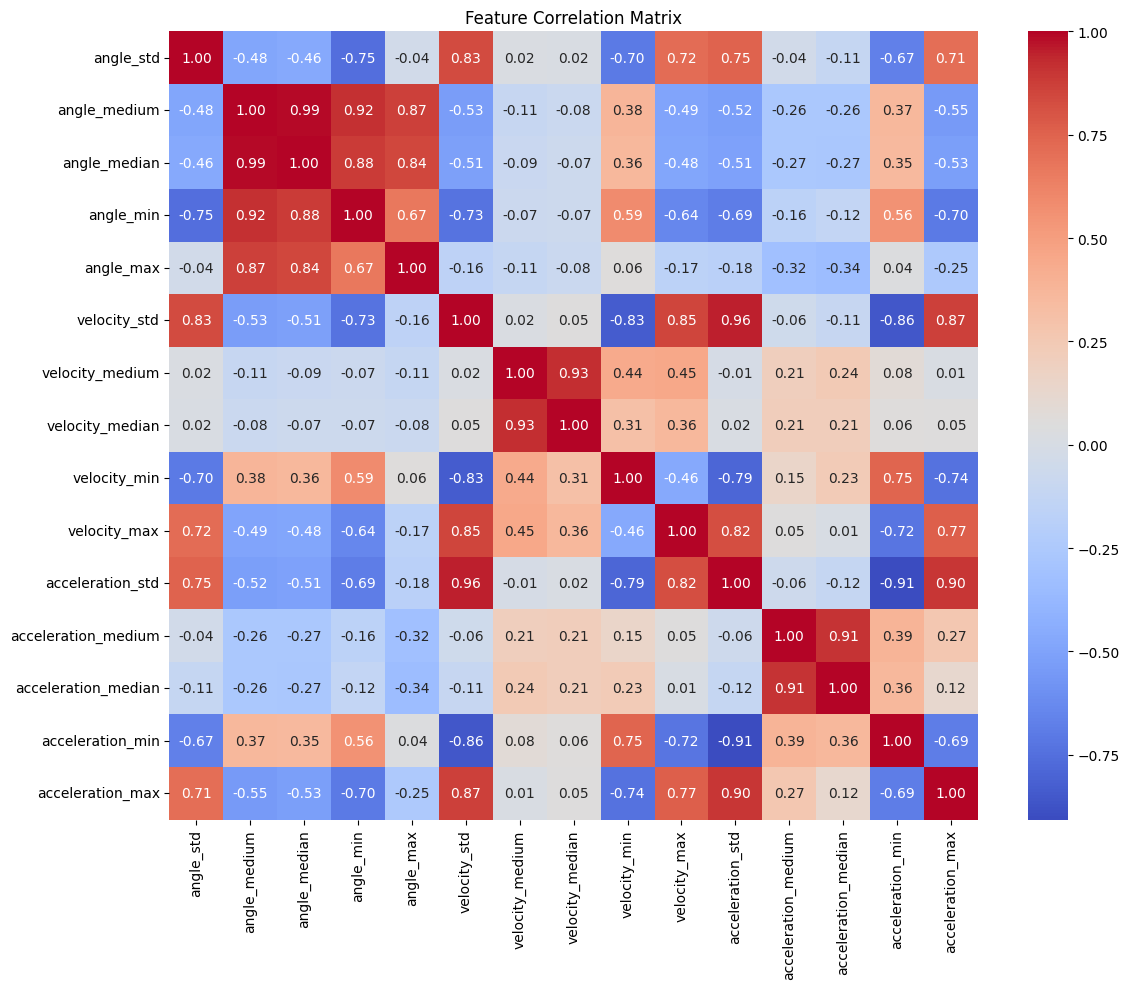

In [117]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features with increased figure size for better visibility
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### **Create and Build Model with Hyperparameter Tuning**

In [80]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search using the balanced and scaled data
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best model
rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict and report
y_pred = rf.predict(X_test)

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


### **Test Model with Hyperparameter Tuning**

              precision    recall  f1-score   support

      direct       0.60      0.50      0.55         6
    indirect       0.84      0.89      0.86        18

    accuracy                           0.79        24
   macro avg       0.72      0.69      0.71        24
weighted avg       0.78      0.79      0.79        24



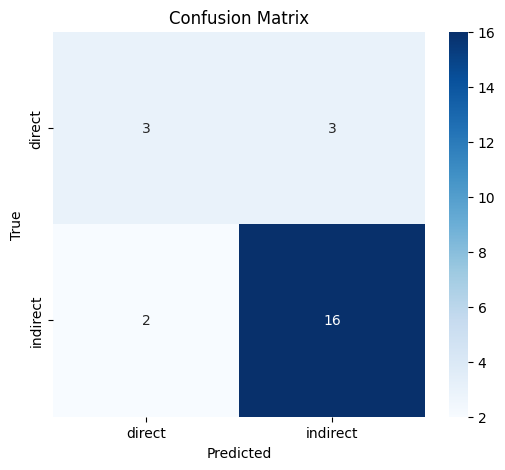

Feature Importances:
acceleration_min: 0.1312
acceleration_std: 0.0931
velocity_min: 0.0891
velocity_std: 0.0884
velocity_max: 0.0862
angle_min: 0.0773
velocity_medium: 0.0650
angle_max: 0.0612
acceleration_max: 0.0562
angle_std: 0.0557
angle_median: 0.0485
angle_medium: 0.0439
acceleration_median: 0.0427
velocity_median: 0.0411
acceleration_medium: 0.0203


C:\Users\asus\AppData\Local\Temp\ipykernel_9128\1907170430.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


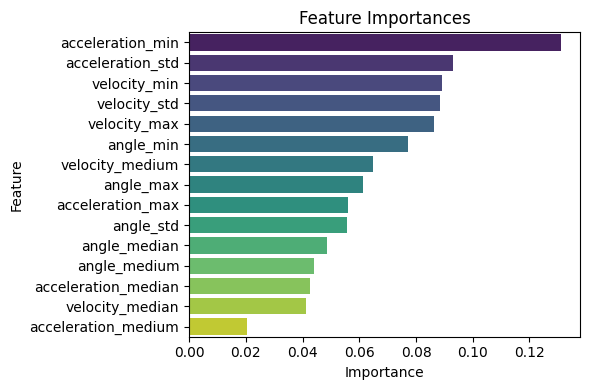

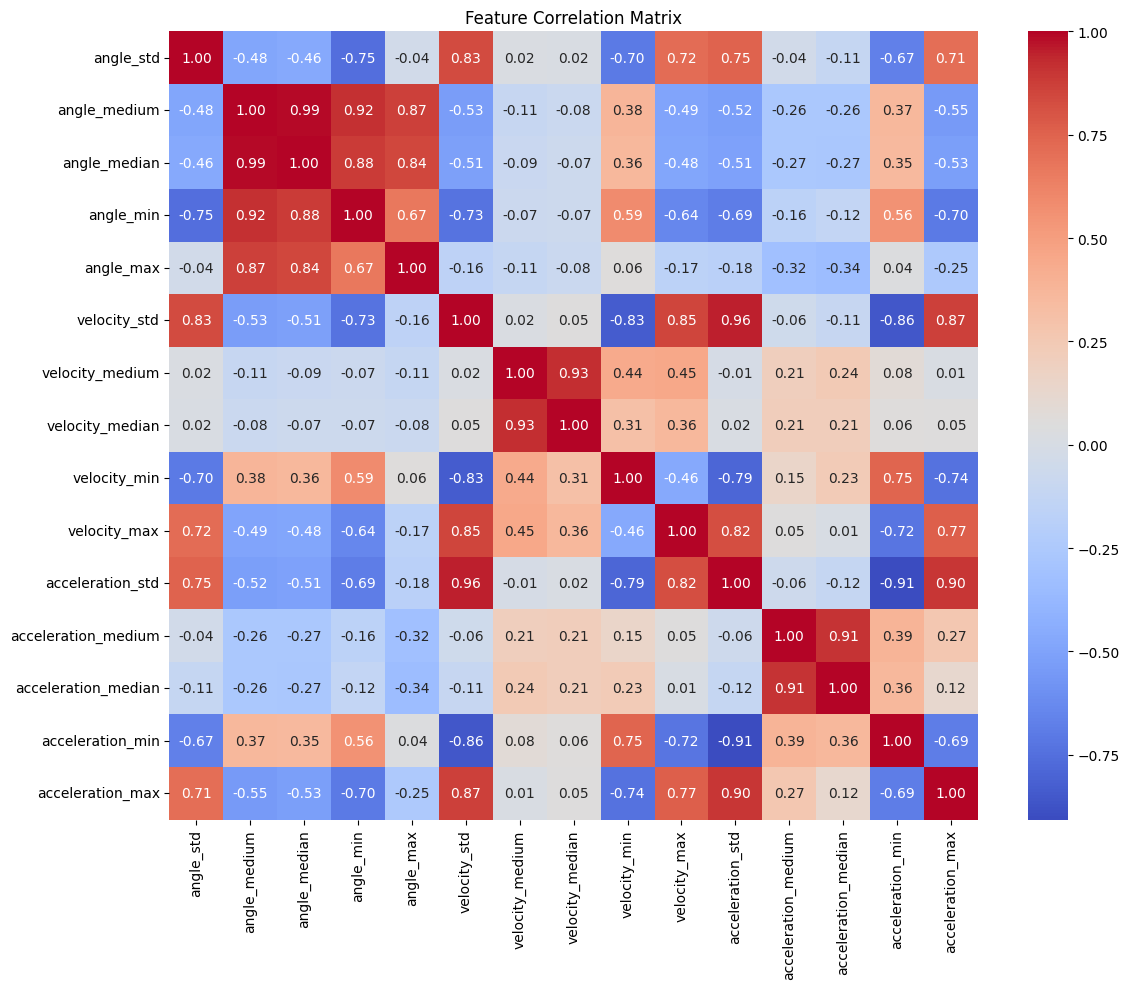

In [81]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [61]:
# Separate classes
df_direct = df_all[df_all['Classification'] == 'direct']
df_indirect = df_all[df_all['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

### **Try XGBoost Model**

              precision    recall  f1-score   support

      direct       0.94      0.94      0.94        18
    indirect       0.93      0.93      0.93        14

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



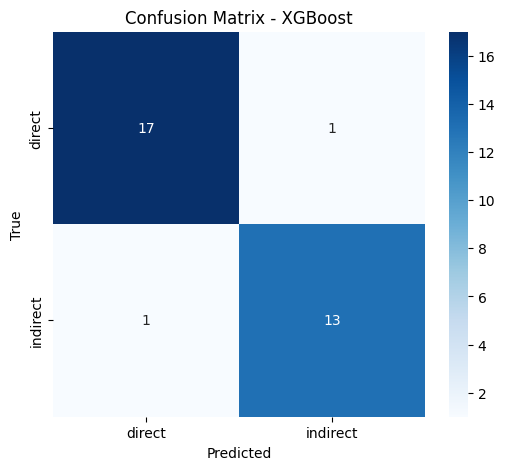

Feature Importances (XGBoost):
acceleration_std: 0.2139
velocity_std: 0.0971
angle_max: 0.0904
angle_min: 0.0876
velocity_min: 0.0833
angle_std: 0.0685
acceleration_medium: 0.0594
acceleration_max: 0.0546
acceleration_min: 0.0497
angle_medium: 0.0472
velocity_max: 0.0468
angle_median: 0.0329
acceleration_median: 0.0320
velocity_medium: 0.0192
velocity_median: 0.0175


C:\Users\asus\AppData\Local\Temp\ipykernel_9128\1569712675.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


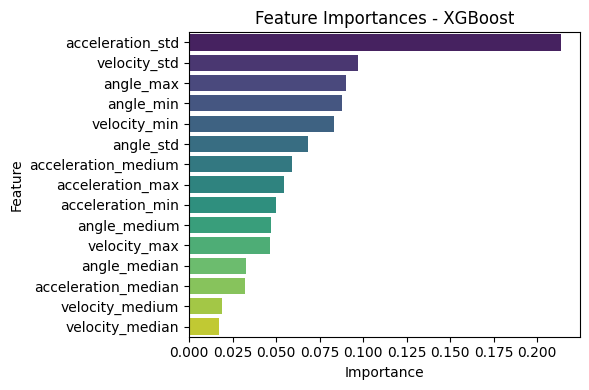

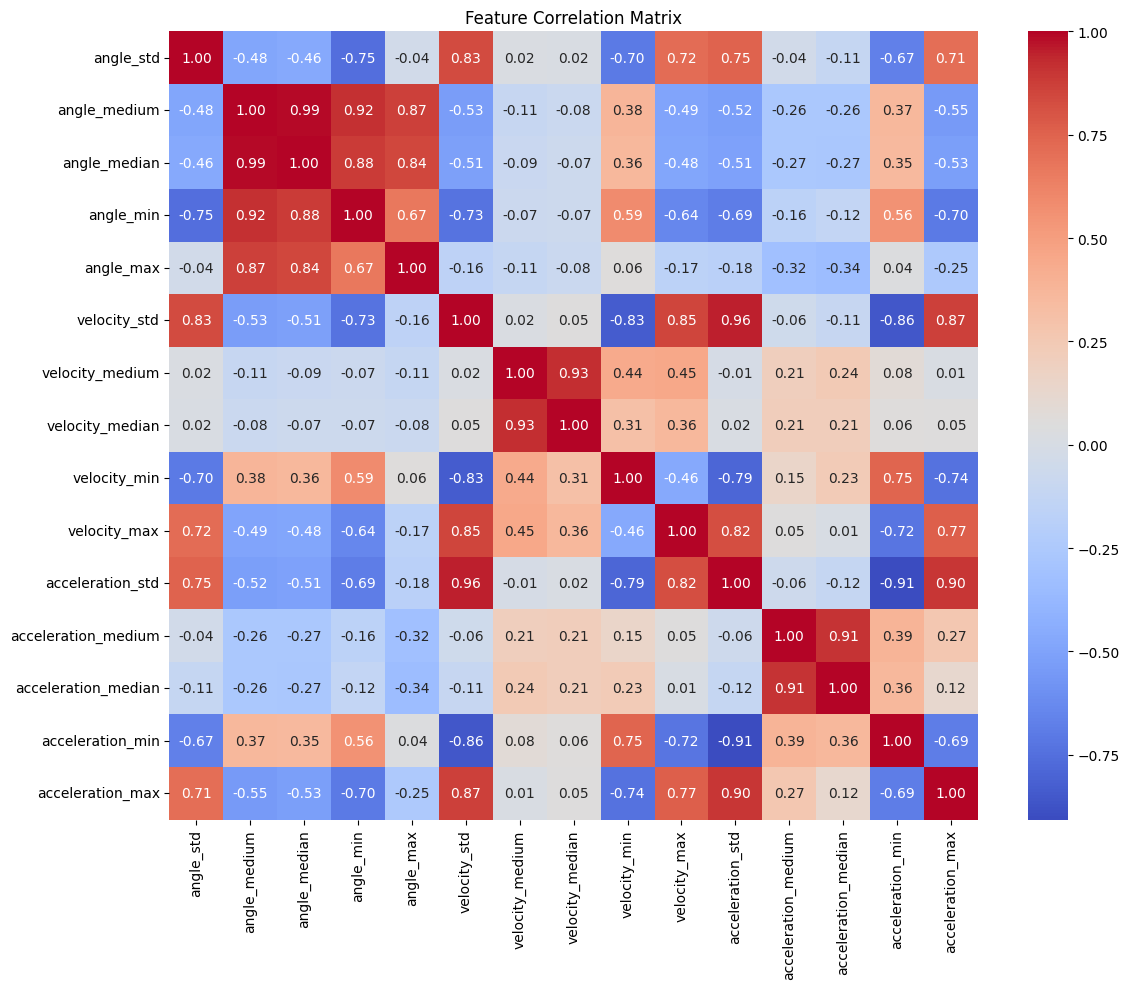

In [75]:
# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train_encoded)

# Predict and evaluate
y_pred_encoded = xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Feature importances
importances = xgb.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (XGBoost):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()